In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import time
import tensorflow as tf
from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers6 import *
import seaborn as sns
from sklearn import metrics

from dataset_path import output_path
path = output_path

In [8]:
df = pd.read_csv('df_master_3.csv')
confidence_interval = 95
random_seed=0

In [49]:
def PlotROCCurve(probs,y_test_roc, ci= 95, random_seed=0):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test_roc,probs)
    roc_auc = metrics.auc(fpr, tpr)
    average_precision = average_precision_score(y_test_roc, probs)
    a=np.sqrt(np.square(fpr-0)+np.square(tpr-1)).argmin()
    sensitivity = tpr[a]
    specificity = 1-fpr[a]
    threshold = threshold[a]
    print("AUC:",roc_auc)
    print("AUPRC:", average_precision)
    print("Sensitivity:",sensitivity)
    print("Specificity:",specificity)
    print("Score thresold:",threshold)
    lower_auroc, upper_auroc, std_auroc, lower_ap, upper_ap, std_ap, lower_sensitivity, upper_sensitivity, std_sensitivity, lower_specificity, upper_specificity, std_specificity = auc_with_ci(probs,y_test_roc, lower = (100-ci)/2, upper = 100-(100-ci)/2, n_bootstraps=20, rng_seed=random_seed)


    plt.title('Receiver Operating Characteristic: AUC={0:0.4f}'.format(
          roc_auc))
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    precision, recall, threshold2 = precision_recall_curve(y_test_roc, probs)
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUPRC={0:0.4f}'.format(
          average_precision))
    plt.show()
    return [roc_auc, average_precision, sensitivity, specificity, threshold, lower_auroc, upper_auroc, std_auroc, lower_ap, upper_ap, std_ap, lower_sensitivity, upper_sensitivity, std_sensitivity, lower_specificity, upper_specificity, std_specificity,fpr, tpr]


In [9]:
df.drop('triage_pain', axis=1, inplace=True)

In [10]:
df.dropna(subset = ["age", "gender", 'triage_sbp_recoded', 'triage_dbp_recoded', 'triage_pain_recoded'], inplace = True)

In [11]:
df.rename(columns={'race_recoded': 'race', 'triage_temperature_recoded_2': 'triage_temperature','triage_heartrate_recoded': 'triage_heartrate',
                  'triage_resprate_recoded': 'triage_resprate','triage_o2sat_recoded': 'triage_o2sat','triage_sbp_recoded': 'triage_sbp',
                  'triage_dbp_recoded': 'triage_dbp','triage_pain_recoded': 'triage_pain'}, inplace=True)

In [6]:
df.to_csv(os.path.join(path, 'df.csv'), index=False)

In [87]:
df.head()

,index,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,...,ed_sbp_last_recoded,ed_dbp_last_recoded,ed_pain_last_recoded,n_med,n_medrecon,ed_death,n_ed_30d,n_ed_90d,n_ed_365d,MAP
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180/05/06 11:30:00 pm,52.0,F,2180.0,2180/09/09 12:00:00 am,...,107,60,0.0,0,9,False,0,0,0,77.333333
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180/06/26 9:31:00 pm,52.0,F,2180.0,2180/09/09 12:00:00 am,...,96,57,5.0,3,12,False,0,1,1,97.333333
2,2,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180/07/23 5:54:00 am,52.0,F,2180.0,2180/09/09 12:00:00 am,...,81,38,0.0,2,14,False,1,2,2,52.333333
3,3,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180/07/23 2:00:00 pm,52.0,F,2180.0,2180/09/09 12:00:00 am,...,86,45,2.0,8,14,False,2,3,3,65.333333
4,4,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180/08/06 1:44:00 am,52.0,F,2180.0,2180/09/09 12:00:00 am,...,98,60,2.0,6,7,False,2,3,4,73.333333


In [50]:
add_triage_MAP(df) # add an extra variable MAP
add_score_CCI(df)
add_score_CART(df)
add_score_REMS(df)
add_score_NEWS(df)
add_score_NEWS2(df)
add_score_MEWS(df)

Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_MEWS' successfully added


In [51]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=25)

In [52]:
print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")

No. of training examples: 342236
No. of testing examples: 85559


### 1. Variable Selection

In [53]:
variable = ["age", "gender", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression",
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "MAP"]

outcome = "outcome_hospitalization"

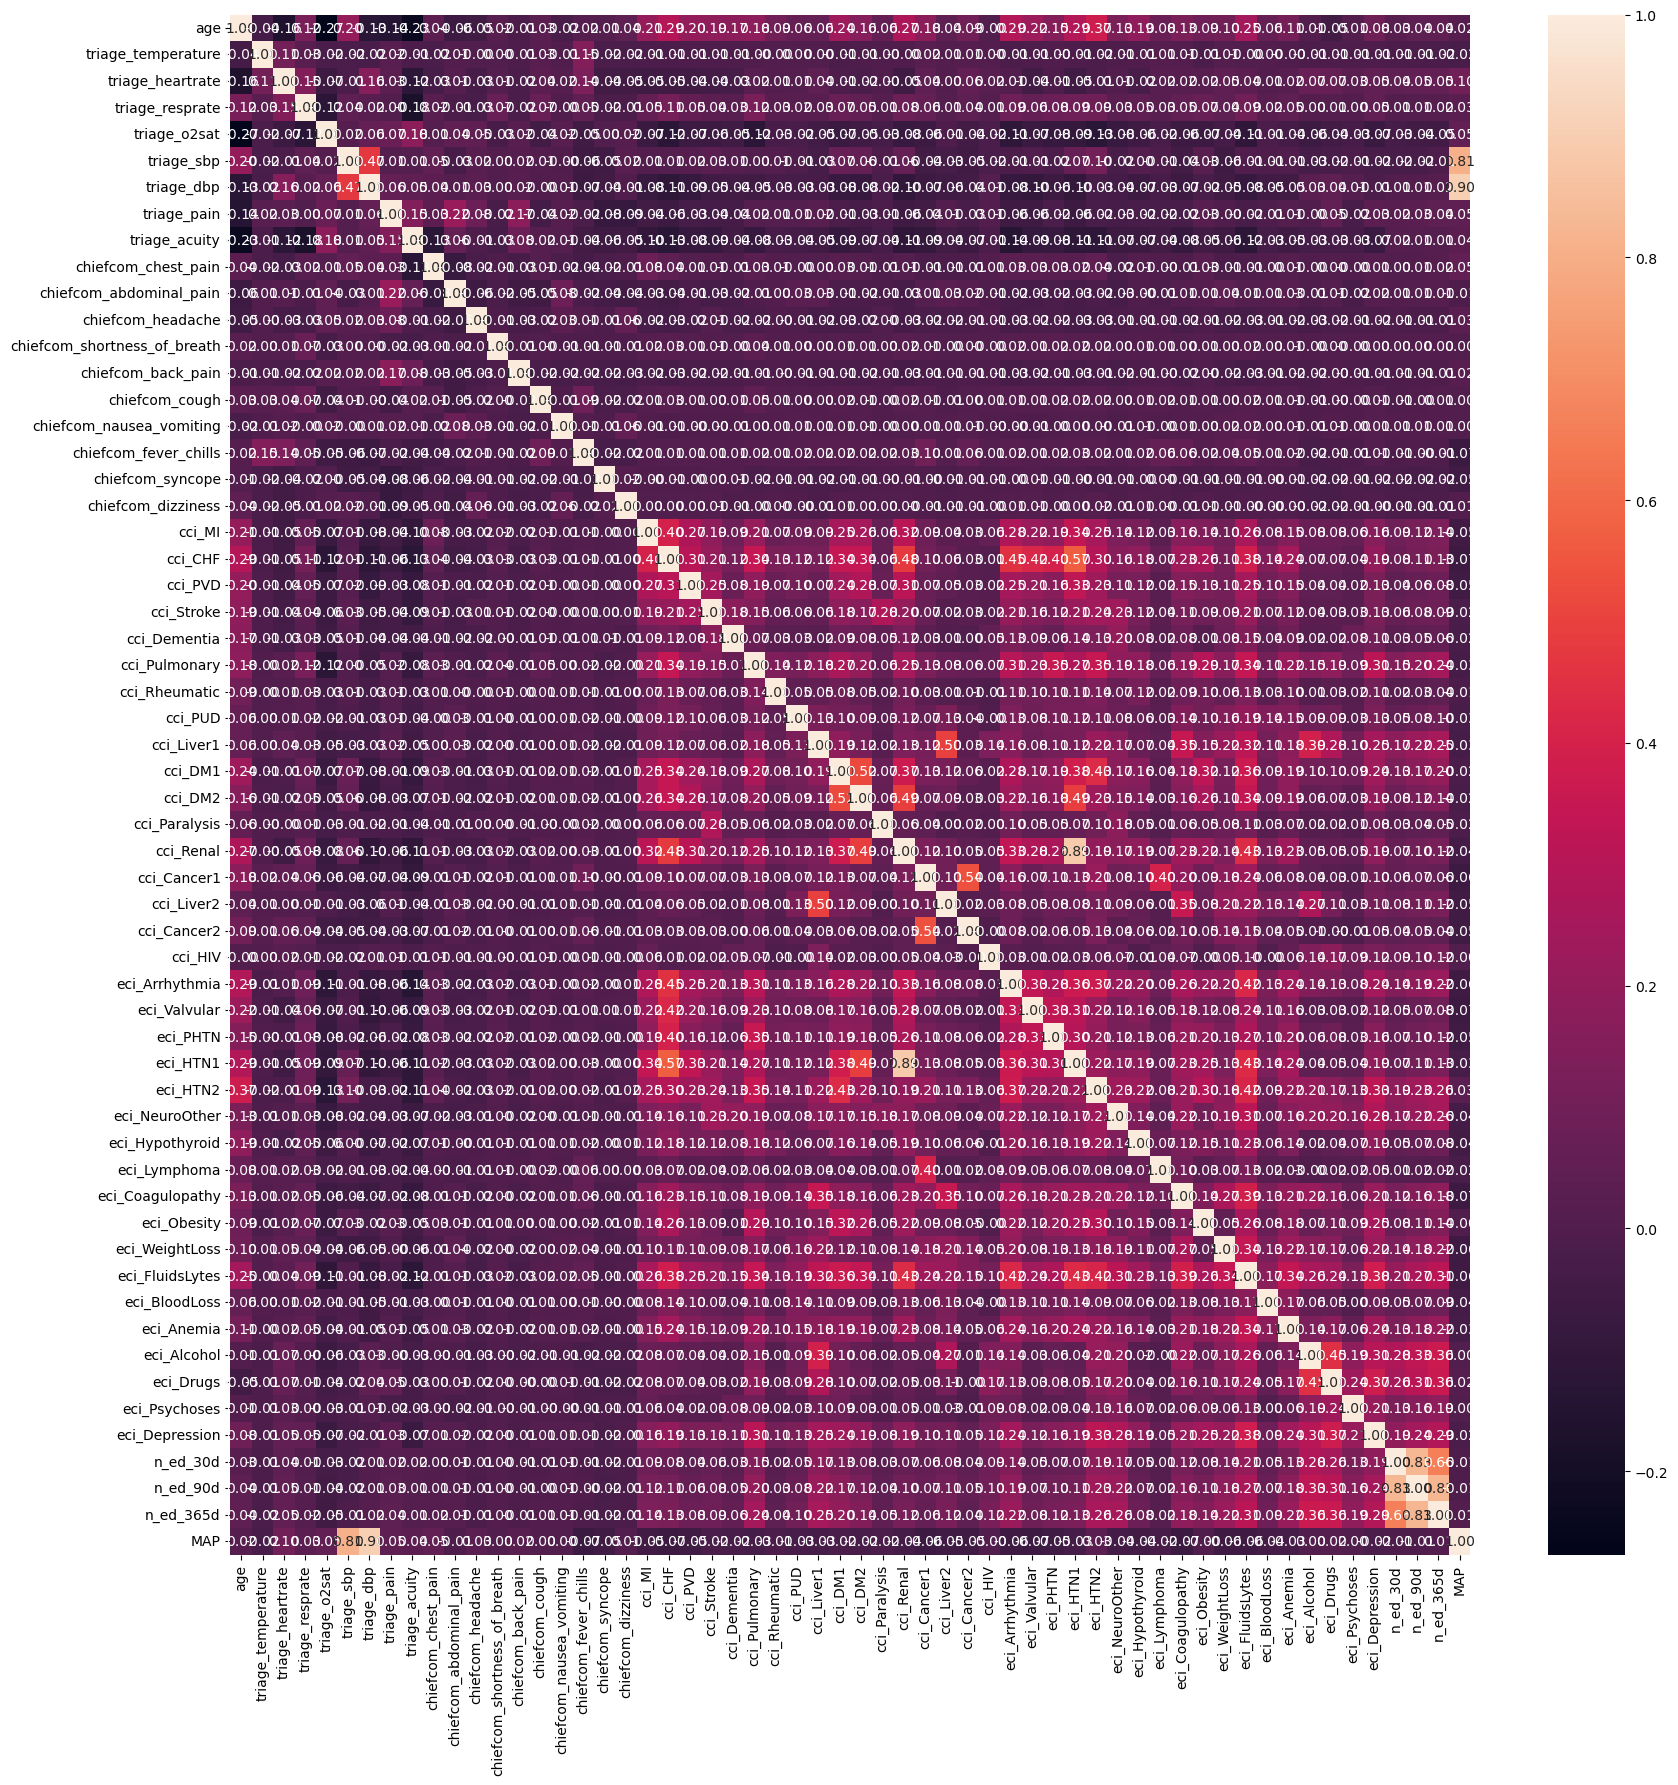

In [16]:
# Check for correlation among numerical attributes
corr = df_train[variable].corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corr, annot = True, fmt=".2f")
plt.show()

In [54]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [55]:
X_train.dtypes.to_frame().T

,age,gender,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,...,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,n_ed_30d,n_ed_90d,n_ed_365d,MAP
0,float64,object,float64,float64,int64,float64,float64,float64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64


In [56]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [57]:
# Standardize the data since we have numerical values like sbp and dbp in large range
# https://scikit-learn.org/stable/modules/preprocessing.html
scale_features = ["age","triage_temperature", "triage_heartrate", "triage_resprate", "triage_o2sat", "triage_sbp", "triage_dbp", 
                  "triage_pain","triage_acuity","n_ed_30d", "n_ed_90d", "n_ed_365d", "MAP"]
scaler = StandardScaler()
scaler.fit(X_train[scale_features])


X_train[scale_features] = scaler.transform(X_train[scale_features])
X_test[scale_features] = scaler.transform(X_test[scale_features])

In [58]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8683247988295537 : 1


In [59]:
X_train.head()

,age,gender,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,...,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,n_ed_30d,n_ed_90d,n_ed_365d,MAP
28787,0.746205,1,1.003525,2.103643,1.928713,-2.591872,-2.101189,-0.561659,-1.153233,-2.433378,...,0,0,0,0,0,0,-0.305007,-0.331390,0.881740,-1.406223
82959,0.162974,1,-0.177230,-0.400169,0.197867,0.773147,0.360600,0.747709,1.512678,-0.963867,...,0,0,0,0,0,0,-0.305007,-0.331390,-0.338477,0.677823
170961,0.017166,0,0.198465,1.022451,-0.667556,-0.188287,0.450119,0.027557,-1.153233,0.505644,...,0,0,0,0,0,0,-0.305007,-0.331390,-0.338477,0.239076
403354,0.600397,0,0.144794,0.510308,-0.667556,0.292430,0.629159,-0.168849,-0.086869,0.505644,...,0,0,0,0,0,0,-0.305007,-0.331390,-0.338477,0.195202
168532,-1.149297,0,0.520489,-0.172550,1.063290,0.773147,-1.295513,-1.216343,-1.153233,3.444667,...,0,0,0,0,0,0,0.990662,0.302758,-0.094434,-1.450097


### 2. Modeling Script

In [60]:
# Containers for all results
result_list = []

### Logistic Regression

Logistic Regression:
Training time: 3.4955482482910156 seconds
AUC: 0.8050479174059727
AUPRC: 0.7681458171073277
Sensitivity: 0.7351031561003735
Specificity: 0.7212052202855391
Score thresold: 0.44597745607382455
2.5 97.5


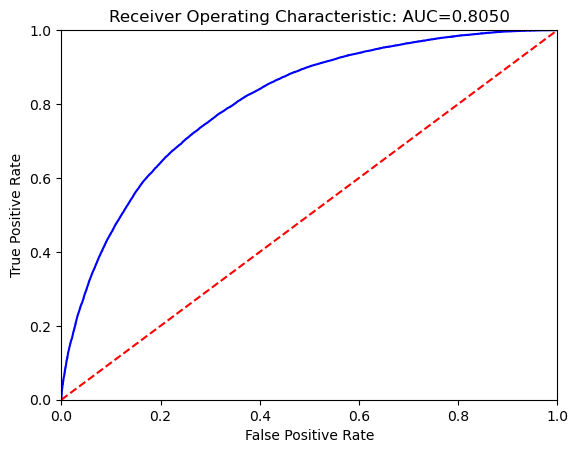

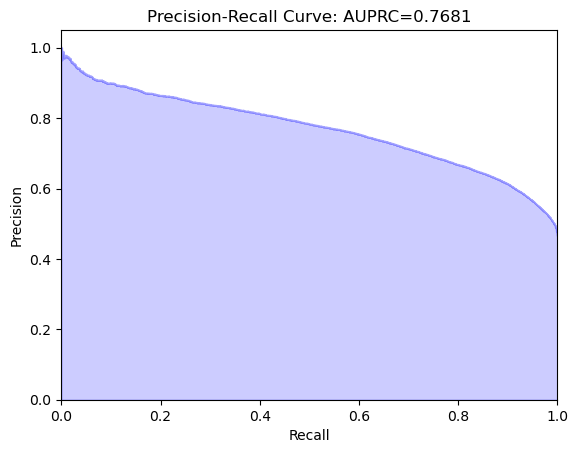

In [61]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### Hyper parameter tuning for Logistic Regression

In [64]:
model=LogisticRegression()

# define the parameters for tuning
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
penalty = ['l2']
c_values = [10, 1.0, 0.1, 0.01]
max_iter = [1000]
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)

# define cross validation parameters
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

start = time.time()

# use grid search to find the best parameters
lr_model = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1)
lr_model.fit(X_train, y_train)

runtime = time.time()-start
print('LR Training time:', runtime, 'seconds')

# summarize results for hypertuning for Logistic Regression
print("Best: %f using %s" % (lr_model.best_score_, lr_model.best_params_))

LR Training time: 268.8696563243866 seconds
Best: 0.726329 using {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [65]:
#predict using the tuned model
ht_y_prob = lr_model.predict_proba(X_test)
ht_y_pred = lr_model.predict(X_test)

Logistic Regression with Hyper Parameter Tuning:
AUC: 0.8050829871323153
AUPRC: 0.7680596542215283
Sensitivity: 0.7399664084630618
Specificity: 0.7167600945957782
Score thresold: 0.44187626684938214
2.5 97.5


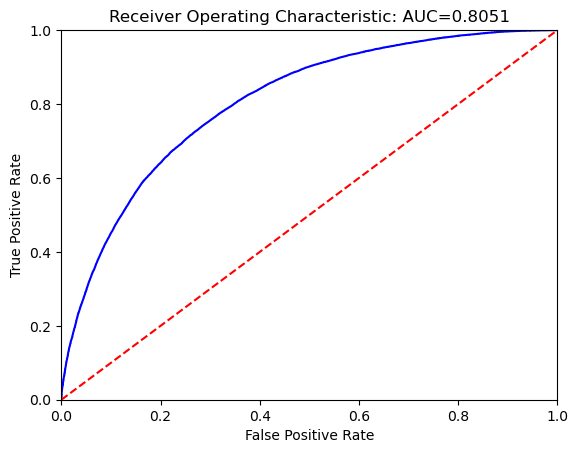

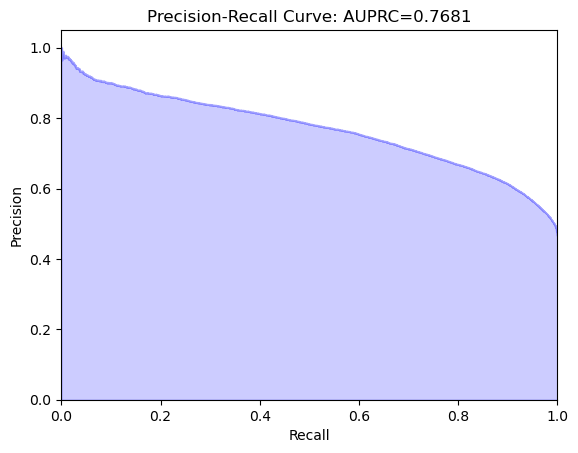

In [66]:
print("Logistic Regression with Hyper Parameter Tuning:")
confidence_interval = 95
result = PlotROCCurve(ht_y_prob[:,1],y_test, ci=confidence_interval)

results = ["LR_HT"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### Random Forest

RandomForest:
Training time: 196.46683025360107 seconds
AUC: 0.8143389996521286
AUPRC: 0.7776599051333062
Sensitivity: 0.7387631295279637
Specificity: 0.7352851011649295
Score thresold: 0.49
2.5 97.5


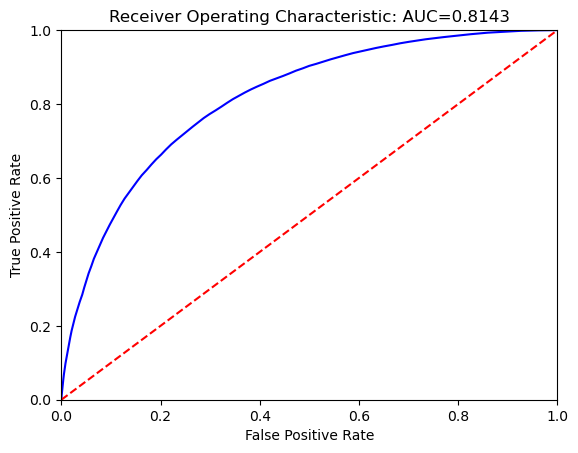

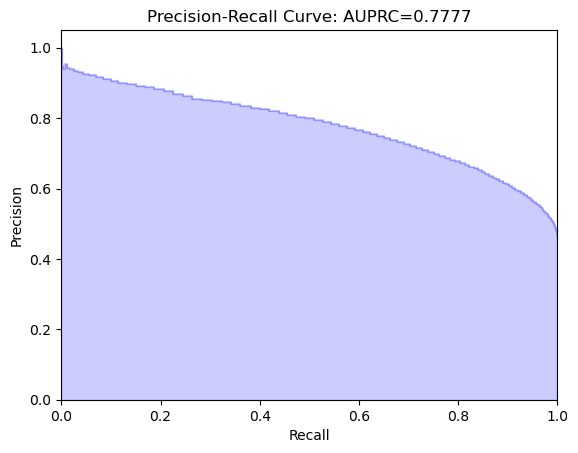

In [67]:
print("RandomForest:")

rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
#print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### Hyper Parameter Tuning for Random Forest

In [68]:
variable_selected = ['age','MAP','triage_acuity','triage_heartrate','triage_temperature','triage_resprate','triage_o2sat','n_ed_365d']

X_train_selected = X_train[variable_selected].copy()
X_test_selected = X_test[variable_selected].copy()

RandomForest with Best Parameters:
Training time: 19.113274812698364 seconds
AUC: 0.792313721726249
AUPRC: 0.7607804626837935
Sensitivity: 0.7235717329723497
Specificity: 0.7081107120959972
Score thresold: 0.4617137643553843
2.5 97.5


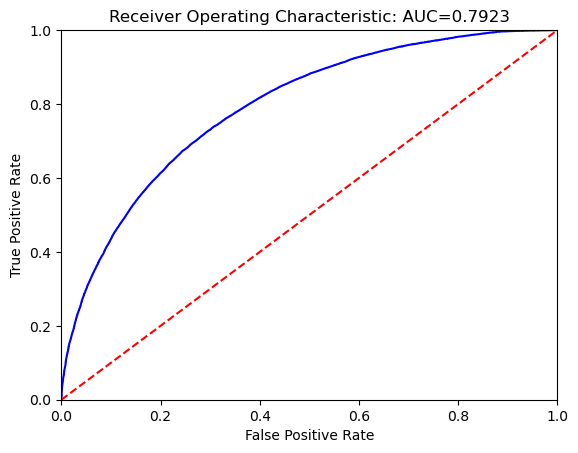

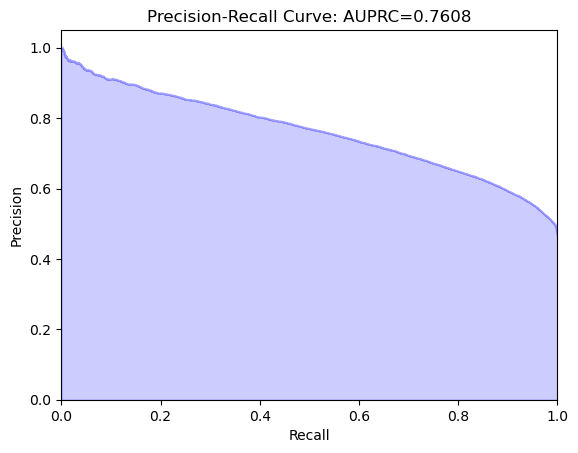

In [69]:
print("RandomForest with Best Parameters:")

rf= RandomForestClassifier(n_estimators=32, max_depth=12)
start = time.time()
rf.fit(X_train_selected,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test_selected)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
#print(importances)

results = ["RF with BP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [70]:
# define model and parameters
model = RandomForestClassifier()
n_estimators = [32,34]
#max_features = np.arange(1,20,2).tolist()
max_features = ['auto','log2']

max_depth = [8,10,12]
min_samples_split = [0.1, 0.2]
min_samples_leaf = [0.1,0.05]


# define grid search
grid = dict(n_estimators=n_estimators, max_depth = max_depth)
#cv = RepeatedStratifiedKFold(n_splits=10,  random_state=1)

start = time.time()

# use grid search to find the best parameters
rf_model =  GridSearchCV(estimator=model, param_grid=grid, n_jobs = -1)
rf_model.fit(X_train_selected, y_train)


runtime = time.time()-start
print('RF Training time with HT:', runtime, 'seconds')

# summarize results for hypertuning for Logistic Regression
print("Best: %f using %s" % (rf_model.best_score_, rf_model.best_params_))

RF Training time with HT: 111.60922574996948 seconds
Best: 0.714998 using {'max_depth': 12, 'n_estimators': 34}


In [71]:
# predict using the tuned model
ht_y_prob = rf_model.predict_proba(X_test_selected)
ht_y_pred = rf_model.predict(X_test_selected)

AUC: 0.7926296599549354
AUPRC: 0.7612951276356711
Sensitivity: 0.7206136722569001
Specificity: 0.7118770254883069
Score thresold: 0.46551674413304284
2.5 97.5


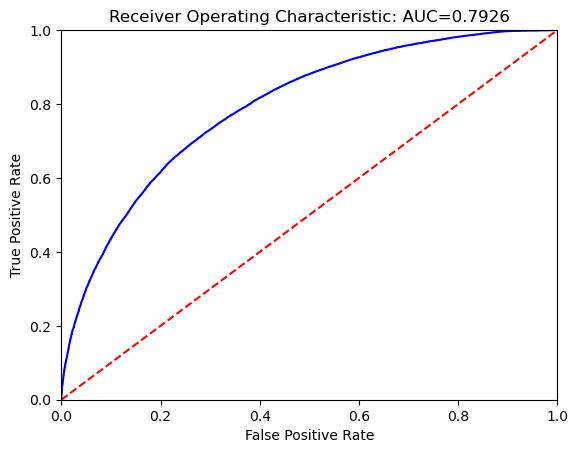

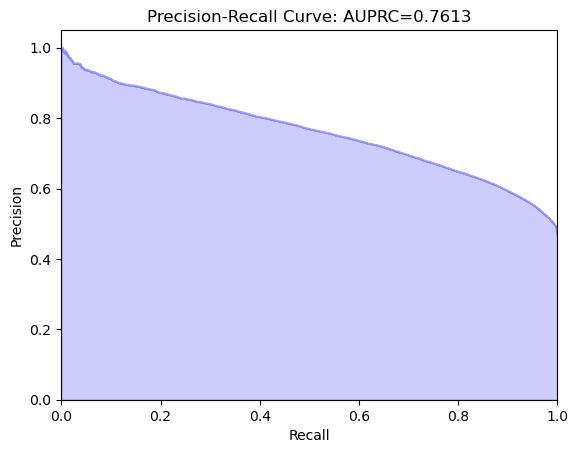

In [72]:
result = PlotROCCurve(ht_y_prob[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF with HT"]
results.extend(result)
results.append(runtime)
result_list.append(results)

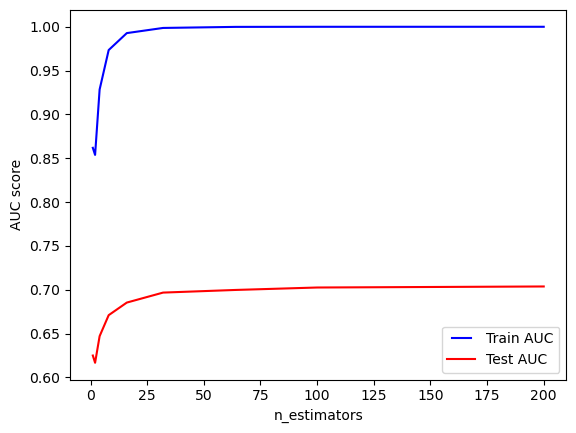

In [24]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train_selected, y_train)
   train_pred = rf.predict(X_train_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

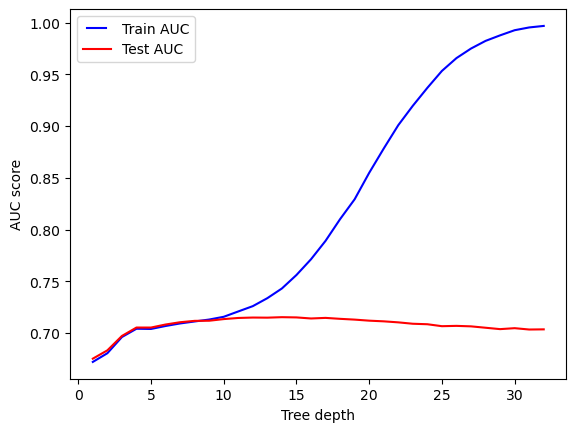

In [26]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train_selected, y_train)
   train_pred = rf.predict(X_train_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

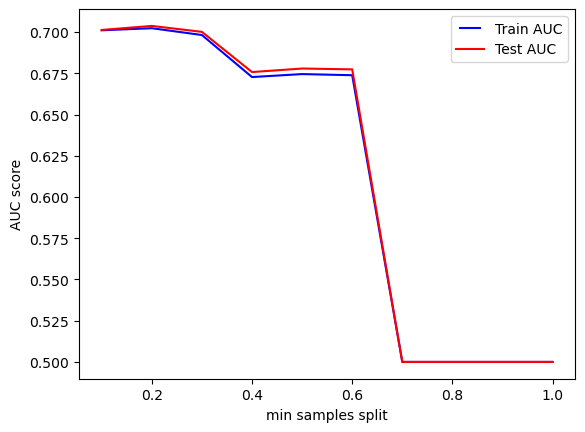

In [27]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train_selected, y_train)
   train_pred = rf.predict(X_train_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

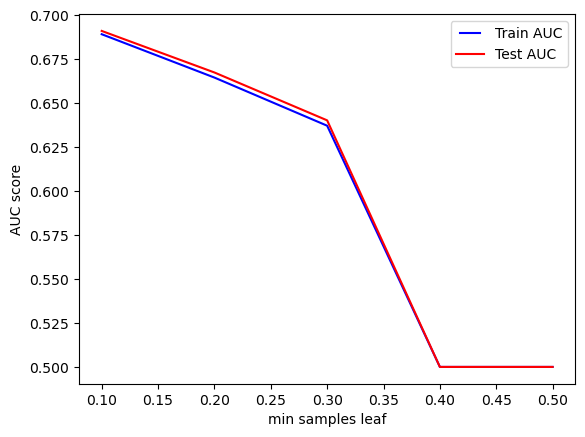

In [28]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(X_train_selected, y_train)
   train_pred = rf.predict(X_train_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

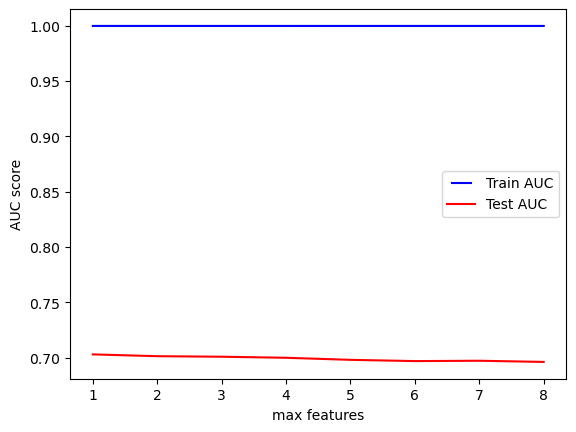

In [30]:
max_features = list(range(1,9))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train_selected, y_train)
   train_pred = rf.predict(X_train_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test_selected)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

### Gradient Boosting

GradientBoosting:
Training time: 193.0149028301239 seconds
AUC: 0.8120682005636244
AUPRC: 0.7806176912122306
Sensitivity: 0.736456844902359
Specificity: 0.7321100113865289
Score thresold: 0.47193902009297445
2.5 97.5


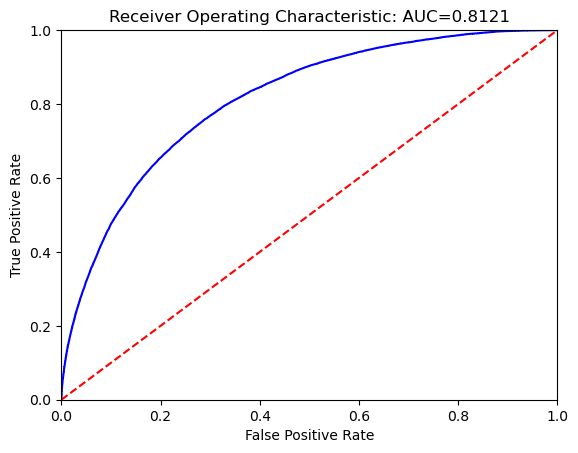

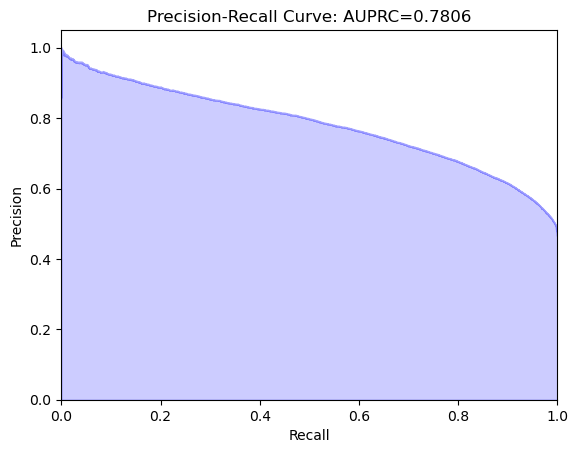

In [73]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### Multi Layer Perceptron

In [ ]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [19]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC',
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1712/1712 [==============================] - 3s 1ms/step - loss: 0.6047 - accuracy: 0.7030 - auc: 0.7670 - true_positives: 102416.0000 - true_negatives: 138189.0000 - precision: 0.6948 - recall: 0.6439
Epoch 2/20
1712/1712 [==============================] - 2s 1ms/step - loss: 0.5522 - accuracy: 0.7183 - auc: 0.7910 - true_positives: 106588.0000 - true_negatives: 139238.0000 - precision: 0.7081 - recall: 0.6701
Epoch 3/20
1712/1712 [==============================] - 2s 1ms/step - loss: 0.5474 - accuracy: 0.7206 - auc: 0.7949 - true_positives: 107798.0000 - true_negatives: 138832.0000 - precision: 0.7085 - recall: 0.6777
Epoch 4/20
1712/1712 [==============================] - 2s 1ms/step - loss: 0.5447 - accuracy: 0.7218 - auc: 0.7967 - true_positives: 108899.0000 - true_negatives: 138135.0000 - precision: 0.7074 - recall: 0.6846
Epoch 5/20
1712/1712 [==============================] - 2s 1ms/step - loss: 0.5407 - accuracy: 0.7244 - auc: 0.8000 - true_positives: 109661.0000 - 

MLP:
2674/2674 [==============================] - 7s 2ms/step
AUC: 0.7493817242596568
AUPRC: 0.7002009114205029
Sensitivity: 0.6871976134967788
Specificity: 0.6783962512043444
Score thresold: 0.5387392
2.5 97.5


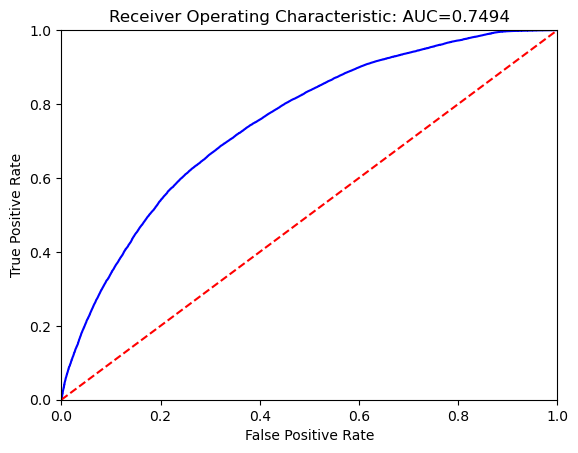

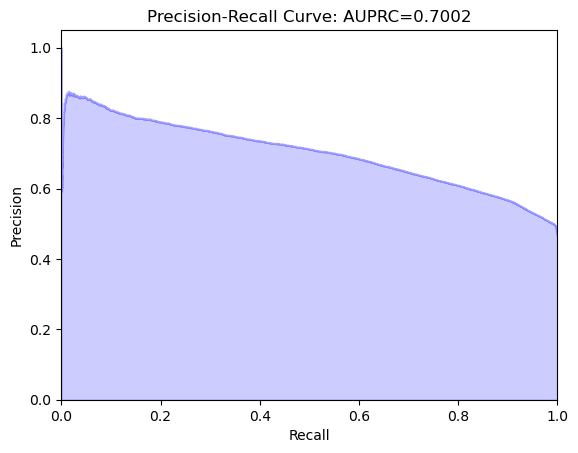

In [75]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### Gaussian Naive Bayes

In [76]:
continuous_attributes = ["age",  
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "MAP"]

In [77]:
nb_X_train = X_train[continuous_attributes].copy()
nb_X_test = X_test[continuous_attributes].copy()

Gaussian Naive Bayes:
Training time: 0.25075316429138184 seconds
AUC: 0.7688800908419211
AUPRC: 0.711761334228944
Sensitivity: 0.7133187937128675
Specificity: 0.6914469650521153
Score thresold: 0.2871352524656753
2.5 97.5


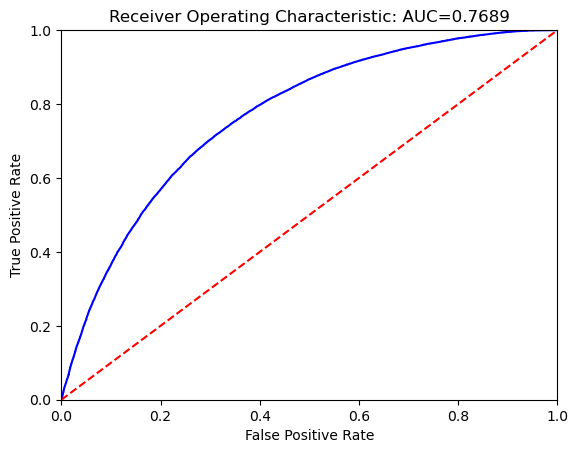

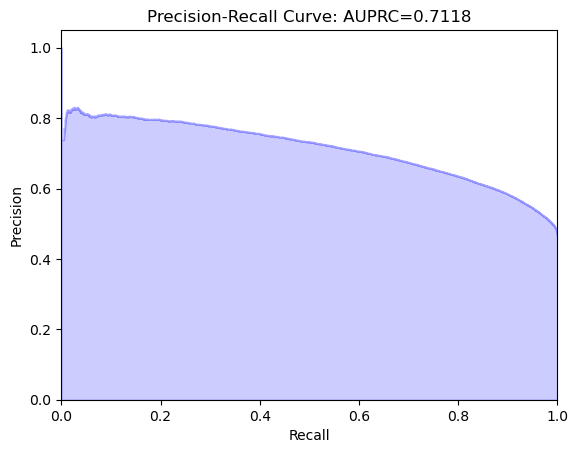

In [78]:
print("Gaussian Naive Bayes:")
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
start = time.time()
nb_model.fit(nb_X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = nb_model.predict_proba(nb_X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["NB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [79]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)

score_NEWS
AUC: 0.5899642414165795
AUPRC: 0.5550797905137
Sensitivity: 0.5510265473415056
Specificity: 0.5786984321625646
Score thresold: 3
2.5 97.5


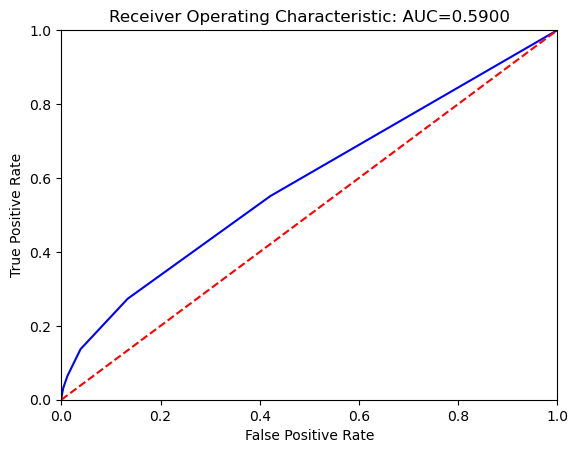

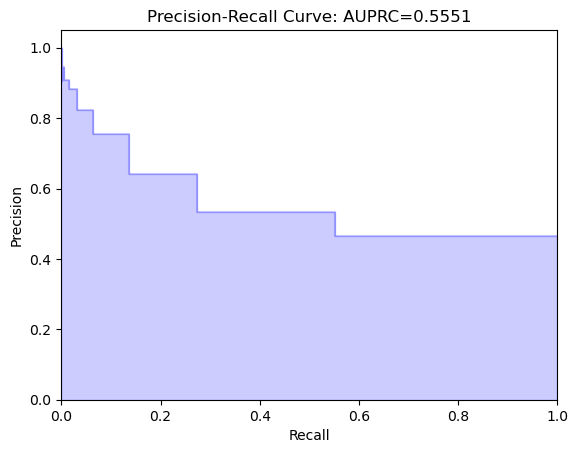

In [80]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5685892632465073
AUPRC: 0.5347648874226344
Sensitivity: 0.49537489659321654
Specificity: 0.602938600332837
Score thresold: 3
2.5 97.5


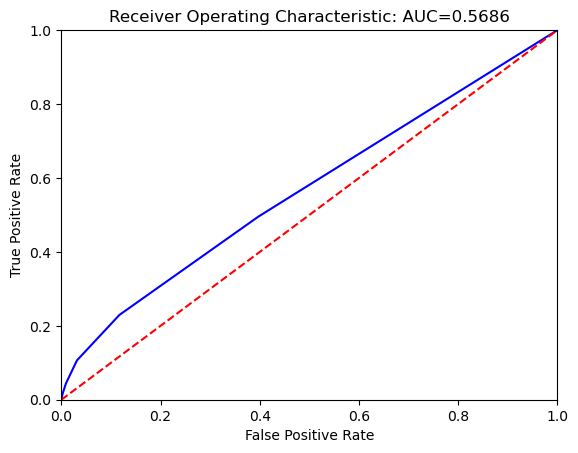

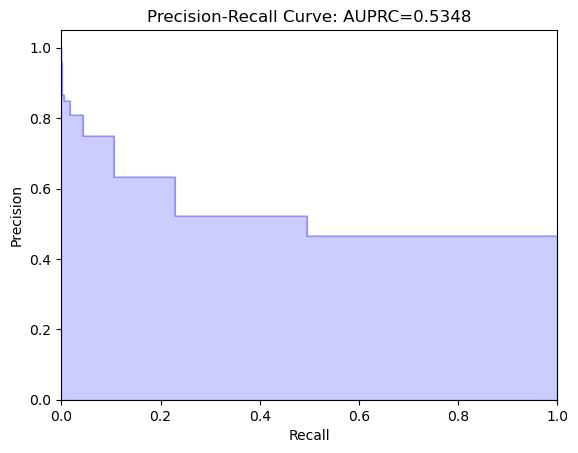

In [81]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6746550843450083
AUPRC: 0.6046447232208567
Sensitivity: 0.7211150384798576
Specificity: 0.5581807830428309
Score thresold: 3
2.5 97.5


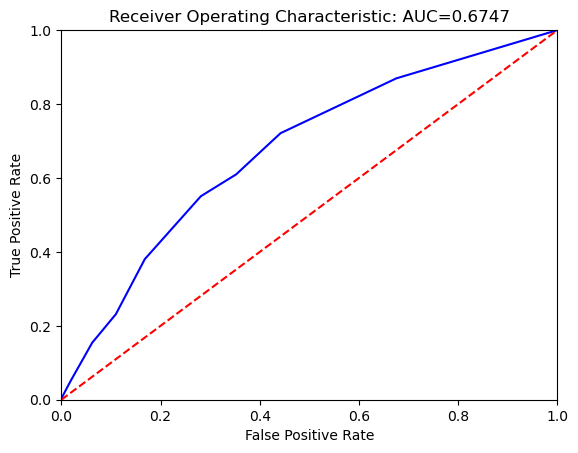

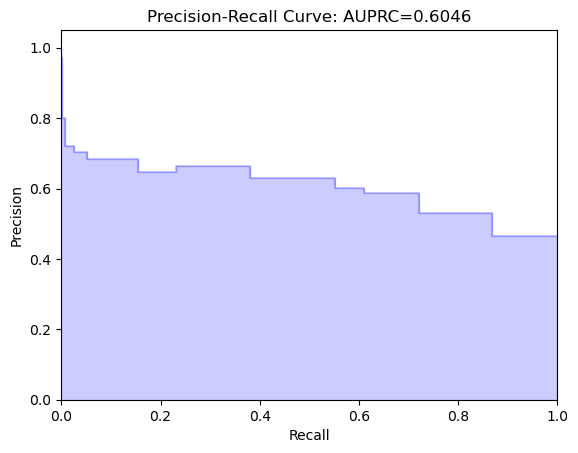

In [82]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5619321717107866
AUPRC: 0.5167292906376877
Sensitivity: 0.30553257627033664
Specificity: 0.8110274152579486
Score thresold: 4
2.5 97.5


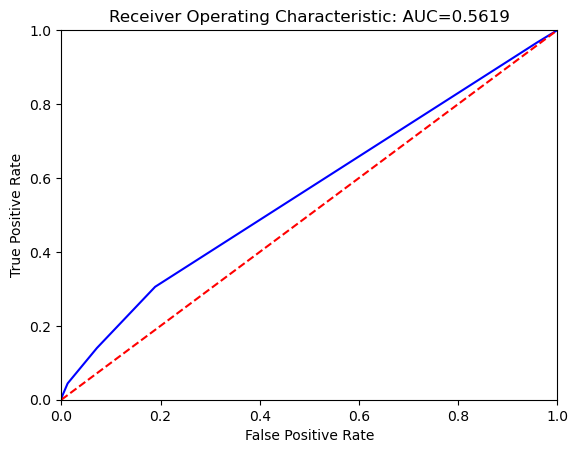

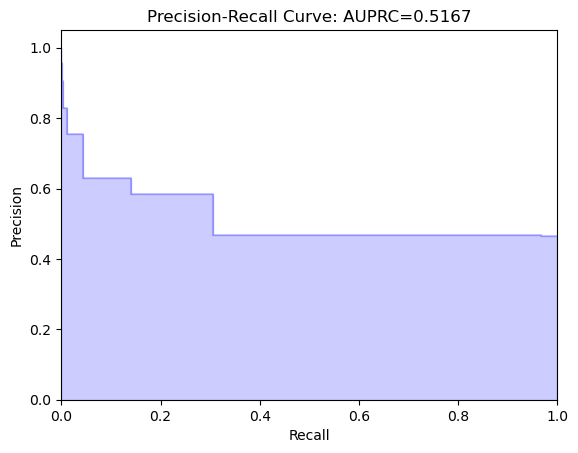

In [83]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 3. Performance output

In [86]:
## Please note : Need to add fpr and tpr to the return list in PlotROCCurve function in helper6.py
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'fpr','tpr','runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.446,0.805 (0.802-0.807),0.768 (0.764-0.77),0.735 (0.724-0.74),0.721 (0.717-0.732),3.496
1,LR_HT,0.442,0.805 (0.802-0.807),0.768 (0.764-0.77),0.74 (0.721-0.743),0.717 (0.713-0.735),268.870
2,RF,0.490,0.814 (0.812-0.816),0.778 (0.773-0.78),0.739 (0.737-0.753),0.735 (0.722-0.737),196.467
3,RF with BP,0.462,0.792 (0.789-0.794),0.761 (0.757-0.763),0.724 (0.703-0.733),0.708 (0.7-0.729),19.113
4,RF with HT,0.466,0.793 (0.789-0.794),0.761 (0.757-0.764),0.721 (0.708-0.725),0.712 (0.706-0.725),111.609
5,GB,0.472,0.812 (0.81-0.814),0.781 (0.777-0.783),0.736 (0.734-0.751),0.732 (0.718-0.736),193.015
6,MLP,0.539,0.749 (0.747-0.752),0.7 (0.694-0.703),0.687 (0.668-0.693),0.678 (0.675-0.699),193.015
7,NB,0.287,0.769 (0.766-0.771),0.712 (0.706-0.714),0.713 (0.699-0.719),0.691 (0.686-0.706),0.251
8,score_NEWS,3.000,0.59 (0.587-0.593),0.555 (0.551-0.558),0.551 (0.547-0.555),0.579 (0.573-0.583),0.000
9,score_NEWS2,3.000,0.569 (0.566-0.572),0.535 (0.53-0.538),0.495 (0.491-0.498),0.603 (0.597-0.607),0.000


In [87]:
def CompareModels(df):
    plt.title('Model Comparison')
    for row in df.itertuples():
        plt.plot(row.fpr, row.tpr, marker = '.', label = row.Model,markersize = 1)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

In [88]:
compare_df = result_df[['Model','threshold','fpr','tpr']].copy()

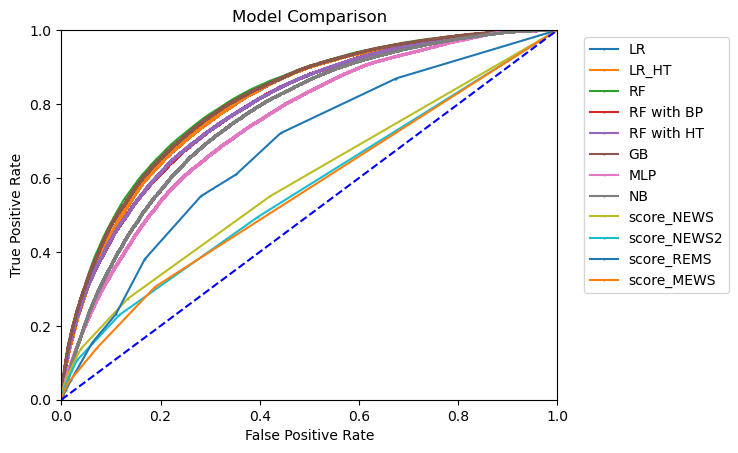

In [89]:
CompareModels(compare_df)

In [27]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.119592
9,triage_acuity,0.105383
58,MAP,0.080750
3,triage_heartrate,0.079800
6,triage_sbp,0.077667
2,triage_temperature,0.073572
7,triage_dbp,0.072698
5,triage_o2sat,0.043812
8,triage_pain,0.043399
4,triage_resprate,0.038427
